In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader
from utils.utils import *

random.seed(1)

# Autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
data_folder = "data"

image_files = [f for f in os.listdir(data_folder) if f.endswith("png")]

### Chose a random image to train a neural representation on

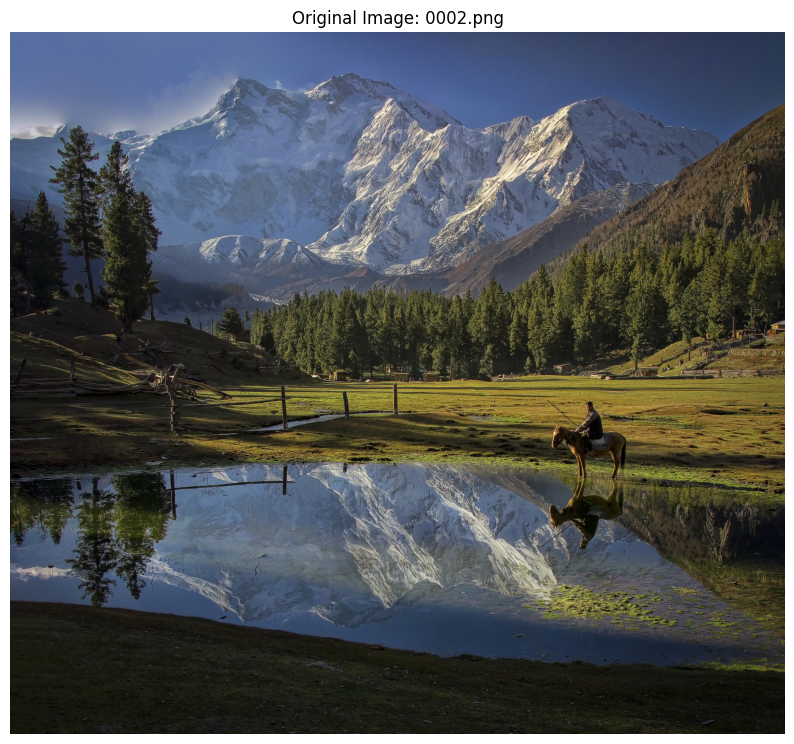

Image dimensions: 1848x2040, 3 channels


In [3]:
# Choose a random image to train on
img_file_path = '0002.png'
img_path = os.path.join(data_folder, img_file_path)
img_original = Image.open(img_path)

# Convert image to numpy array
img_np_original = np.array(img_original)

# Display the original image
plt.figure(figsize=(10, 10))
plt.imshow(img_np_original)
plt.axis("off")
plt.title(f"Original Image: {img_file_path}")
plt.show()

# Get image dimensions
height_target, width_target, channels = img_np_original.shape
print(f"Image dimensions: {height_target}x{width_target}, {channels} channels")

Downsize factor: 3


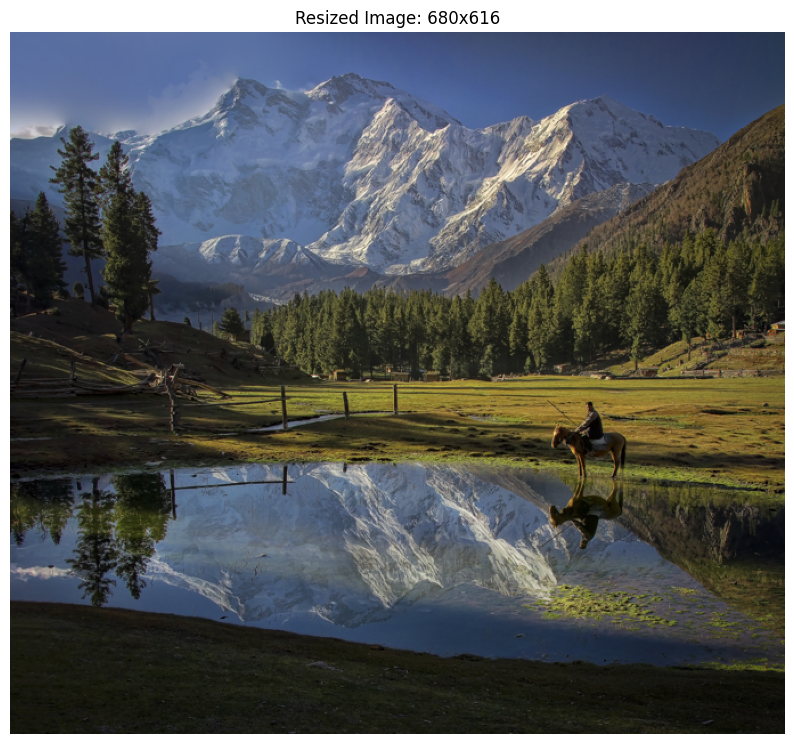

Resized image dimensions: 616x680, 3 channels


In [4]:
# Now we will downsize the original image to a smaller resolution using a random integer factor
downsize_factor = 3
print(f"Downsize factor: {downsize_factor}")
img_resized = img_original.resize((width_target // downsize_factor, height_target // downsize_factor))

# convert image to numpy array
img_np_resized = np.array(img_resized)

# Display the resized image
plt.figure(figsize=(10, 10))
plt.imshow(img_np_resized)
plt.axis("off")
plt.title(f"Resized Image: {width_target // downsize_factor}x{height_target // downsize_factor}")
plt.show()

# Print the resolution of the new image
height_resized, width_resized, channels = img_np_resized.shape
print(f"Resized image dimensions: {height_resized}x{width_resized}, {channels} channels")

### We will next normalize the pixels to have values between 0 and 1

In [5]:
# Normalize the resized image
img_np_resized_standardized = img_np_resized / 255.0  # Normalize to [0, 1]

In [6]:
# Print the mean of the resized image
print(f"Resized image mean: {np.mean(img_np_resized_standardized, axis=(0, 1))}")
print(f"Resized image std: {np.std(img_np_resized_standardized, axis=(0, 1))}")

Resized image mean: [0.27551185 0.29086209 0.29602895]
Resized image std: [0.15515677 0.15763278 0.2025867 ]


### Normalize the coordinates of the image to be between 0 and 1.

In [7]:
normalized_coordinates = get_normalized_coordinates(height_resized, width_resized)
pixel_values = img_np_resized_standardized.reshape(-1, channels)

# Check shapes
print(f"Normalized coordinates shape: {normalized_coordinates.shape}")
print(f"Pixel values shape: {pixel_values.shape}")

Normalized coordinates shape: (418880, 2)
Pixel values shape: (418880, 3)


### Create the dataset and dataloader for the downsampled image

In [8]:
# Create dataset and dataloader
dataset = ImageDataset(normalized_coordinates, pixel_values)
dataloader = DataLoader(dataset, batch_size=4096, shuffle=True)

  0%|          | 1/300 [00:01<08:45,  1.76s/it]

Epoch 0, Loss: 0.044407


  4%|▎         | 11/300 [00:16<07:17,  1.51s/it]

Epoch 10, Loss: 0.010492


  7%|▋         | 21/300 [00:32<07:18,  1.57s/it]

Epoch 20, Loss: 0.009488


 10%|█         | 31/300 [00:47<06:52,  1.53s/it]

Epoch 30, Loss: 0.009058


 14%|█▎        | 41/300 [01:02<06:26,  1.49s/it]

Epoch 40, Loss: 0.008826


 17%|█▋        | 51/300 [01:18<06:31,  1.57s/it]

Epoch 50, Loss: 0.008682


 20%|██        | 61/300 [01:33<06:02,  1.51s/it]

Epoch 60, Loss: 0.008598


 24%|██▎       | 71/300 [01:48<05:44,  1.51s/it]

Epoch 70, Loss: 0.008522


 27%|██▋       | 81/300 [02:03<05:31,  1.51s/it]

Epoch 80, Loss: 0.008504


 30%|███       | 91/300 [02:18<05:13,  1.50s/it]

Epoch 90, Loss: 0.008466


 34%|███▎      | 101/300 [02:33<04:56,  1.49s/it]

Epoch 100, Loss: 0.008436


 37%|███▋      | 111/300 [02:49<04:48,  1.53s/it]

Epoch 110, Loss: 0.008419


 40%|████      | 121/300 [03:04<04:28,  1.50s/it]

Epoch 120, Loss: 0.008400


 44%|████▎     | 131/300 [03:19<04:15,  1.51s/it]

Epoch 130, Loss: 0.008363


 47%|████▋     | 141/300 [03:34<04:00,  1.51s/it]

Epoch 140, Loss: 0.008343


 50%|█████     | 151/300 [03:49<03:49,  1.54s/it]

Epoch 150, Loss: 0.008348


 54%|█████▎    | 161/300 [04:04<03:28,  1.50s/it]

Epoch 160, Loss: 0.008353


 57%|█████▋    | 171/300 [04:19<03:15,  1.51s/it]

Epoch 170, Loss: 0.008334


 60%|██████    | 181/300 [04:34<02:59,  1.51s/it]

Epoch 180, Loss: 0.008333


 64%|██████▎   | 191/300 [04:50<02:45,  1.52s/it]

Epoch 190, Loss: 0.008311


 67%|██████▋   | 201/300 [05:05<02:32,  1.54s/it]

Epoch 200, Loss: 0.008309


 70%|███████   | 211/300 [05:20<02:14,  1.51s/it]

Epoch 210, Loss: 0.008272


 74%|███████▎  | 221/300 [05:35<01:59,  1.52s/it]

Epoch 220, Loss: 0.008312


 77%|███████▋  | 231/300 [05:51<01:44,  1.51s/it]

Epoch 230, Loss: 0.008291


 80%|████████  | 241/300 [06:05<01:27,  1.49s/it]

Epoch 240, Loss: 0.008290


 84%|████████▎ | 251/300 [06:20<01:13,  1.49s/it]

Epoch 250, Loss: 0.008269


 87%|████████▋ | 261/300 [06:35<00:58,  1.50s/it]

Epoch 260, Loss: 0.008285


 90%|█████████ | 271/300 [06:51<00:44,  1.54s/it]

Epoch 270, Loss: 0.008253


 94%|█████████▎| 281/300 [07:06<00:28,  1.50s/it]

Epoch 280, Loss: 0.008291


 97%|█████████▋| 291/300 [07:21<00:13,  1.53s/it]

Epoch 290, Loss: 0.008274


100%|██████████| 300/300 [07:34<00:00,  1.52s/it]


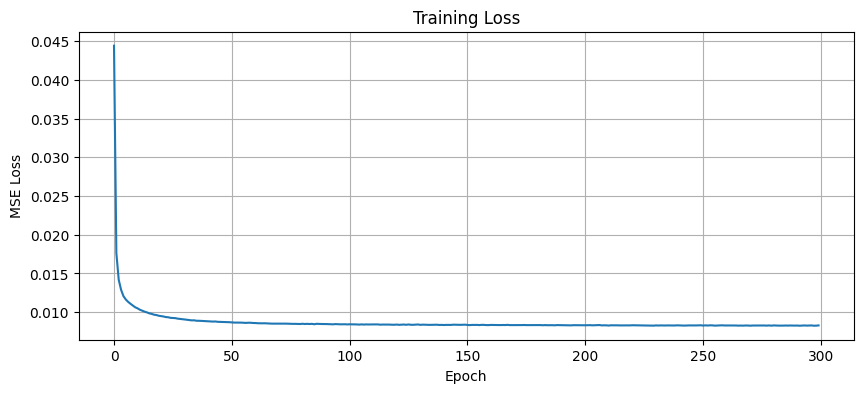

In [9]:
# Create and train the model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
criterion = torch.nn.MSELoss()
model = INRModel(input_dim=2, output_dim=channels, hidden_dim=248, num_layers=3, dropout_rate=0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
losses = model.train_model(dataloader, num_epochs=300, lr=1e-3, device=device, criterion = criterion, optimizer = optimizer)

# Plot the loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

Max and Min values of pred_pixels: 0.8771324753761292, 0.00016152762691490352


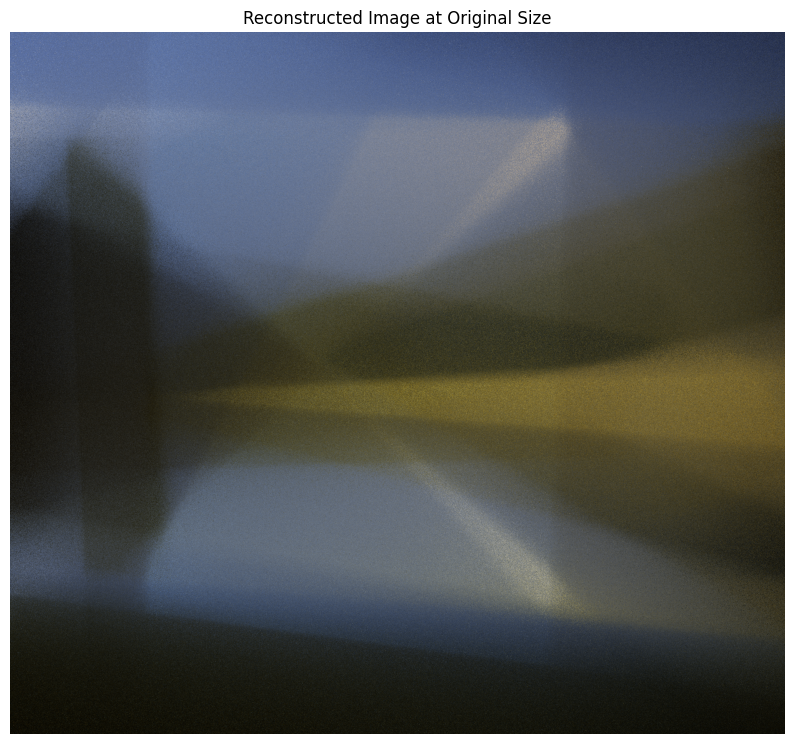

Downsized image shape: (616, 680, 3)
Reconstructed image shape: (1848, 2040, 3)
Original image shape: (1848, 2040, 3)


In [10]:
# Generate normalized coordinates for the original image size
target_coords_normalized = get_normalized_coordinates(height_target, width_target)

# Convert to PyTorch tensor
target_coords_tensor = torch.from_numpy(target_coords_normalized).float().to(device)

# Use the trained model to predict the RGB values for these coordinates
with torch.no_grad():
    pred_pixels = model(target_coords_tensor).cpu().numpy()
    
print(f"Max and Min values of pred_pixels: {np.max(pred_pixels)}, {np.min(pred_pixels)}")

# Denormalize the RGB values using the mean and std of the resized image (i.e the training data)
reconstructed_img_reshaped_normalized = pred_pixels.reshape(height_target, width_target, channels)
# Convert to integer type and denormalize
reconstructed_img_reshaped_denormalized = (reconstructed_img_reshaped_normalized * 255).astype(np.uint8)
# IMPORTANT: Need to round the pixels to the nearest integer value and clip them to [0, 255] range
reconstructed_img_reshaped_denormalized = np.clip(reconstructed_img_reshaped_denormalized, 0, 255)

# Display the reconstructed image
plt.figure(figsize=(10, 10))
plt.imshow(reconstructed_img_reshaped_denormalized)
plt.title('Reconstructed Image at Original Size')
plt.axis('off')
plt.show()

# Check that the shapes of the reconstructed image and original image are the same

print(f"Downsized image shape: {img_np_resized.shape}")
print(f"Reconstructed image shape: {reconstructed_img_reshaped_denormalized.shape}")
print(f"Original image shape: {img_np_original.shape}")